In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=79615e125c20f0f0c3f2dc7f60b002ca98b5a61a6cb7425ec3f5895a252a6721
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
import sys
import math
import numpy as np
from operator import add
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

In [ ]:
import pandas as pd

# Tải dữ liệu PCA
file_path = '/content/pca_data.csv'
df = pd.read_csv(file_path)

# Đổi format dữ liệu phù hợp với Spark
df.to_csv('pca_data.txt', header=False, index=False)


In [ ]:
df.head()

,pc1,pc2,pc3
0,-4.688990,-0.161060,-2.150477
1,2.843035,-0.197029,2.047758
2,-2.508281,0.851942,0.163373
3,2.654625,1.536955,-0.179904
4,0.552305,0.049763,-0.461803


# Khởi tạo các biến toàn cục

In [ ]:
# Tạo hàm tính khoảng cách theo công thức Euclide
def calculateDistance(p1, p2):
  distance = 0
  for i in range(len(p1)):
    distance += (p1[i] - p2[i])**2
    return np.sqrt(distance)

In [ ]:
# Tạo hàm chọn trọng tâm bằng cách so sánh khoảng cách giữa điểm point và tất cả các trọng tâm
# để xem điểm point được đưa vào gần với trọng tâm nào nhất
def selectCentroid(point, centroids):
  bestIndex = 0
  Closest = float("+inf")
  for centroid in centroids:
    if isinstance(point, float):
      tempDist = calculateDistance(point, centroid[1][0])
    else:
      tempDist = calculateDistance(point, centroid[1])
    if tempDist < Closest:
      Closest = tempDist
      bestIndex = centroid[0]
  return bestIndex

In [ ]:
# Tính tổng các hợp phần của các điểm
def partialSum(p1,p2):
  coordinates_sum = list( map(add, p1[0], p2[0]))
  points_number = p1[1] + p2[1]
  p = [coordinates_sum, points_number]
  return p

In [ ]:
#Tính chỉ số WCSS
def computeWCSS(point_rdd, centroids):
  #Chọn điểm dữ liệu và tâm centroids gần nó trong cụm
  wcss = points_rdd.map(lambda point: (selectCentroid(point[0], centroids),point[0]))\
                  .map(lambda x: calculateDistance(x[1],centroids[x[0]][1])**2)\
                  .sum()
  return wcss

Các bước để thực hiện Kmeans trong apacheSpark
1. Khởi tạo môi trường spark
2. Xử lý dữ liệu và lưu ở dạng textfile
3. Khởi tạo centroids: Lựa chọn ngẫu nhiên các centroids
4. Map period:
- Tính toán khoảng cách từ mỗi điểm dữ liệu đến các centroids
- Gán điểm vào centroids gần nhất
- Tạo ra cặp key-value với key là chỉ số centroid còn value giá trị của điểm dữ liệu
5. Reduce
- Tập hợp các điểm cùng một centroid
- Tính toán centroids mới bằng cách tính trung bình điểm dữ liệu trong cụm
6. Lặp lại giai đoạn map reduce đến khi các centroids hội tụ

In [ ]:
#Khai bao
threshold = 0.001  # Ngưỡng hội tụ
filename = 'pca_data.txt'  # Tệp dữ liệu
max_k = 10  # Giá trị k tối đa để kiểm tra


In [ ]:
def kmean(k,lines,points_rdd):
# Khởi tạo các biến trung gian
    convergedCentroids = 0
    centroids = []
    new_centroids = []
    iterations = 0
    maxIterations = 100
    wcss_values = []

    # Khởi tạo centroids bằng hàm takeSample. False là ko bị trung lặp giữa các điểm centroids
    tmp = [line.split(",") for line in lines.takeSample(False, k)]
    # Tạo vòng lặp for qua các trọng tâm trong tmp với index là chỉ số của trọng tâm, centroids
    for index, centroid in enumerate(tmp):
      # Thêm các centroids vào mảng và định dạng các centroids là float để dễ tính toán
        centroids += [[index, [float(string) for string in centroid]]]
    print("các trọng tâm được chọn: ",centroids)
    while maxIterations > iterations:
        iterations += 1

        # MAP để chọn centroids gần nhất cho điểm tương ứng (Đưa h)
        mapped_rdd = points_rdd.keyBy(lambda point: selectCentroid(point[0], centroids))

        # REDUCE tính tổng các khoảng cách tọa đổ của các điểm trong cùng 1 cụm
        reduced_rdd = mapped_rdd.reduceByKey(lambda p1, p2: partialSum(p1, p2))
        reduced_points = reduced_rdd.collect()

        new_centroids = []
        Tính
        for index, reduced_point in enumerate(reduced_points):
            converted_point = list(reduced_point)
            centroid_index = converted_point[0]
            centroid_coordinates = np.array(converted_point[1][0]) / converted_point[1][1]
            new_centroid = [centroid_index, centroid_coordinates]
            new_centroids.append(new_centroid)

        convergedCentroids = 0
        for index, centroid in enumerate(centroids):
            distance = calculateDistance(centroid[1], new_centroids[index][1])
            if distance < threshold:
                convergedCentroids += 1
        centroids = new_centroids

        percentage = len(centroids) / 100

        if convergedCentroids > percentage:
            print(f"Centroids converged for k = {k} in {iterations} iterations")
            break
    clustered_points = mapped_rdd.map(lambda x: (x[1], x[0])).collect()
    wcss = computeWCSS(points_rdd, centroids)
    return wcss,clustered_points,centroids

In [ ]:
# Tạo một SparkSession
spark = SparkSession.builder \
    .appName("KMeansWCSS") \
    .getOrCreate()
sc = SparkContext.getOrCreate()

# Tải và xử lý dữ liệu
lines = sc.textFile(filename, minPartitions = 20)
# Xử lý dữ liệu đưa về mọt
points_rdd = lines.map(lambda line: [[float(string) for string in line.split(',')], 1])
points_rdd.cache()

PythonRDD[112] at RDD at PythonRDD.scala:53

In [ ]:
wcss_values = []
for k in range(1,max_k + 1):
  x,y,z = kmean(k,lines,points_rdd)
  wcss_values.append(x)

sc.stop()

các trọng tâm được chọn:  [[0, [-1.1130427662075777, 2.361818982555972, 1.6782310566059735]]]
Centroids converged for k = 1 in 2 iterations
các trọng tâm được chọn:  [[0, [-2.685851881609304, -4.6529497972947205, -2.018177946276469]], [1, [2.8572714621249324, -0.5491300362737359, 0.2796477509336625]]]
Centroids converged for k = 2 in 7 iterations
các trọng tâm được chọn:  [[0, [3.3857925983749952, -0.4842264413549505, 0.3372384922975041]], [1, [-0.3357769945815397, -1.4477832885252564, 1.1313159458665631]], [2, [-2.7610678713321173, -1.9973311509681697, 0.0010087113476043]]]
Centroids converged for k = 3 in 12 iterations
các trọng tâm được chọn:  [[0, [-0.2913116551536874, -1.840113291730007, -0.5434719222590727]], [1, [-4.252264437714859, 2.1040745365530773, 0.3934828534221763]], [2, [3.09585614833016, 1.6431625097006155, 0.2356675549913497]], [3, [0.3426368995104336, -1.611855112301581, -2.289409059842113]]]
Centroids converged for k = 4 in 13 iterations
các trọng tâm được chọn:  [[0

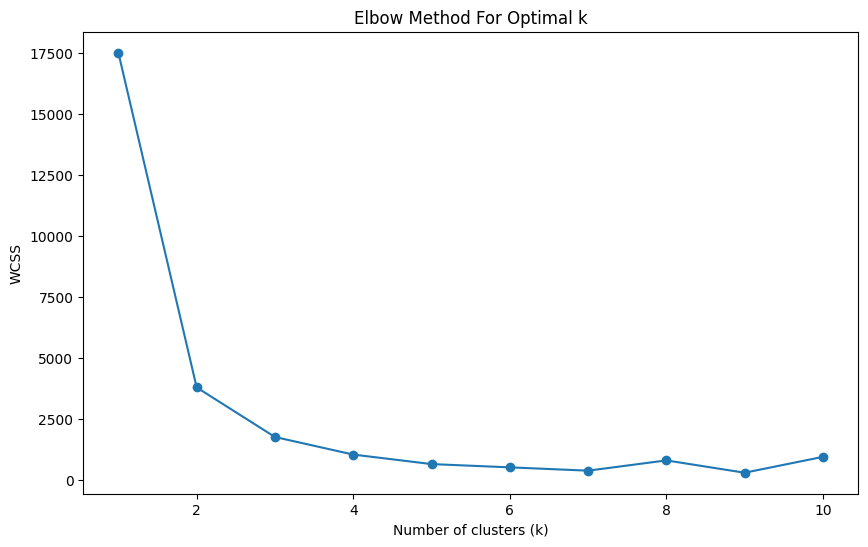

In [ ]:
import matplotlib.pyplot as plt
# Vẽ biểu đồ WCSS
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_k + 1), wcss_values, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.show()

In [ ]:
from itertools import combinations
import numpy as np


def silhouette_coefficient(clustered_points, centroids):
    """Tính toán silhouette coefficient."""
    silhouette_values = []
    for point_cluster, _ in clustered_points:
        point, cluster_index = point_cluster
        a = 0
        b = float('inf')
        cluster_distance_sum = 0
        cluster_size = 0
        for other_point_cluster, other_cluster_index in clustered_points:
            other_point, _ = other_point_cluster
            if cluster_index == other_cluster_index:
                cluster_distance_sum += calculateDistance(point, other_point)
                cluster_size += 1
            else:
                distance = calculateDistance(point, centroids[other_cluster_index][1])
                if distance < b:
                    b = distance
        a = cluster_distance_sum / cluster_size if cluster_size > 1 else 0
        silhouette = (b - a) / max(a, b)
        silhouette_values.append(silhouette)
    return np.mean(silhouette_values)

In [ ]:
def calinski_harabasz_index(clustered_points, centroids):
    """Tính chỉ số Calinski-Harabasz."""
    # Tính toán WCSS (Within Cluster Sum of Squares)
    wcss = 0
    for point_cluster, _ in clustered_points:
        point, cluster_index = point_cluster
        wcss += calculateDistance(point, centroids[cluster_index][1]) ** 2

    # Tính toán BCSS (Between Cluster Sum of Squares)
    bcss = 0
    centroid_means = np.mean([centroid[1] for centroid in centroids], axis=0)
    for centroid in centroids:
        bcss += len(clustered_points) * calculateDistance(centroid[1], centroid_means) ** 2

    # Tính Calinski-Harabasz Index
    k = len(centroids)
    n = len(clustered_points)
    calinski_harabasz = (bcss / (k - 1)) / (wcss / (n - k))
    return calinski_harabasz

các trọng tâm được chọn:  [[0, [1.7577119280308986, 2.564447780731495, 0.3353109971669639]], [1, [2.361217175867554, -0.0941094727271265, -0.6259355747638196]], [2, [2.2527310295295644, 0.575456525759552, 1.5340796531015437]], [3, [3.026574627605007, 0.9330857171103044, -0.7430796450738913]]]
Centroids converged for k = 4 in 23 iterations
[[-4.688990298591092, -0.1610595819195333, -2.150476906920061], 1]
([[2.84303512991608, -0.1970286837025931, 2.047757826841097], 1], 3)
([[-2.508281353080828, 0.8519421916573712, 0.1633727577626868], 1], 2)
Hệ số silhouette_coefficient:  -0.4810014358639396
Hệ số calinski harabasz  2527.5591901852004


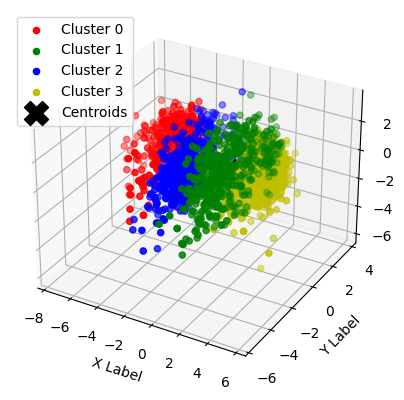

In [ ]:
# Tạo một SparkSession
spark = SparkSession.builder \
    .appName("KMeansWCSS") \
    .getOrCreate()
sc = SparkContext.getOrCreate()

# Tải và xử lý dữ liệu
lines = sc.textFile(filename, minPartitions = 20)
# Xử lý dữ liệu đưa về mọt
points_rdd = lines.map(lambda line: [[float(string) for string in line.split(',')], 1])
points_rdd.cache()

k = 4  # Số lượng cụm
wcss, clustered_points,centroids = kmean(k,lines, points_rdd)
print(clustered_points[0][0])
print(clustered_points[1])
print(clustered_points[2])
print("Hệ số silhouette_coefficient: ",silhouette_coefficient(clustered_points, centroids))
print("Hệ số calinski harabasz ",calinski_harabasz_index(clustered_points, centroids))
# Vẽ biểu đồ 3D của các cụm
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'g', 'b', 'y', 'c', 'm']
for cluster_index in range(k):
      cluster_points = [point[0][0] for point in clustered_points if point[1] == cluster_index]
      cluster_points = np.array(cluster_points)
      ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], c=colors[cluster_index % len(colors)], label=f'Cluster {cluster_index}')

# Vẽ các trọng tâm
centroid_coords = np.array([centroid[1] for centroid in centroids])
ax.scatter(centroid_coords[:, 0], centroid_coords[:, 1], centroid_coords[:, 2], s=300, c='black', marker='X', label='Centroids')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.legend()
plt.show()

spark.stop()

In [ ]:
print(clustered_points[3][0])

[[2.6546251428541296, 1.5369548861577005, -0.1799035634730251], 1]


In [ ]:
for i in range(10):
  print(clustered_points[i])

([[-4.688990298591092, -0.1610595819195333, -2.150476906920061], 1], 2)
([[2.84303512991608, -0.1970286837025931, 2.047757826841097], 1], 1)
([[-2.508281353080828, 0.8519421916573712, 0.1633727577626868], 1], 3)
([[2.6546251428541296, 1.5369548861577005, -0.1799035634730251], 1], 1)
([[0.5523046199295245, 0.0497633519439018, -0.4618029334561381], 1], 0)
([[-0.6374425640296506, -1.260896850240662, 0.737590414865381], 1], 3)
([[-0.5705616469595954, -1.5587626451210113, -0.8541243963699584], 1], 3)
([[2.395849259121841, 0.8991361813361359, -1.496119462970719], 1], 1)
([[2.9725888006414487, 1.231300543824599, -0.94458668557022], 1], 1)
([[5.042755804708938, -0.5893718703335132, -0.6478469358086255], 1], 1)


In [ ]:
for i in range(10):
  print(clustered_points[i][1])

2
1
3
1
0
3
3
1
1
1


In [ ]:
lendf = len(clustered_points)

In [ ]:
print(lendf)

2212


In [ ]:
from pyspark.sql import SparkSession

# Khởi tạo SparkSession
spark = SparkSession.builder.appName("YourAppName").getOrCreate()

labels_df = spark.createDataFrame([(clustered_points[i][1],) for i in range(len(clustered_points))], ["cluster"])


In [ ]:
labels_df.show()
count = labels_df.count()
print(count)

+-------+
|cluster|
+-------+
|      2|
|      1|
|      3|
|      1|
|      0|
|      3|
|      3|
|      1|
|      1|
|      1|
|      0|
|      2|
|      1|
|      0|
|      2|
|      1|
|      0|
|      2|
|      1|
|      0|
+-------+
only showing top 20 rows

2212


In [ ]:
from pyspark.sql.functions import monotonically_increasing_id, col
data = spark.read.csv("/content/data_fixed.csv", header=True, inferSchema=True)

In [ ]:
# Thêm một cột index vào DataFrame `data`
data = data.withColumn("index", monotonically_increasing_id())

In [ ]:
data_test = data.count()
print(data_test)

2212


In [ ]:

# Thêm một cột index vào DataFrame `labels_df`
labels_df = labels_df.withColumn("index", monotonically_increasing_id())

In [ ]:
data_test = labels_df.count()
print(data_test)

2212


In [ ]:

# Sử dụng hàm join để kết hợp `data` và `labels_df` dựa trên cột index
data = data.join(labels_df, on="index",how = "outer")

In [ ]:
data_test = data.count()
print(data_test)

3400


In [ ]:
# Loại bỏ cột index không cần thiết
data = data.drop("index")

In [ ]:
# Hiển thị 10 dòng đầu tiên của DataFrame `data`
data.show(10)
data.describe()

+------+-------+--------+-------+-----+------+----+----+------+----+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+--------+-----------+---+-----------+--------+---------+---------+-----------+-------+
|Income|Kidhome|Teenhome|Recency|Wines|Fruits|Meat|Fish|Sweets|Gold|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|AcceptedCmp3|AcceptedCmp4|AcceptedCmp5|AcceptedCmp1|AcceptedCmp2|Complain|Response|CustomerFor|Age|Total_Spent|Children|Is_Parent|Education|Living_With|cluster|
+------+-------+--------+-------+-----+------+----+----+------+----+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+--------+-----------+---+-----------+--------+---------+---------+-----------+-------+
| 58138|      0|       0|     58|  635|    

DataFrame[summary: string, Income: string, Kidhome: string, Teenhome: string, Recency: string, Wines: string, Fruits: string, Meat: string, Fish: string, Sweets: string, Gold: string, NumDealsPurchases: string, NumWebPurchases: string, NumCatalogPurchases: string, NumStorePurchases: string, NumWebVisitsMonth: string, AcceptedCmp3: string, AcceptedCmp4: string, AcceptedCmp5: string, AcceptedCmp1: string, AcceptedCmp2: string, Complain: string, Response: string, CustomerFor: string, Age: string, Total_Spent: string, Children: string, Is_Parent: string, Education: string, Living_With: string, cluster: string]

In [ ]:
import pandas as pd
data_download = data.toPandas()
# Lưu DataFrame pandas dưới dạng file CSV
data_download.to_csv('data_cluster_kmeans.csv', index=False)

In [ ]:
print(clustered_points)
print(centroids)

[([[-4.688990298591092, -0.1610595819195333, -2.150476906920061], 1], 2), ([[2.84303512991608, -0.1970286837025931, 2.047757826841097], 1], 1), ([[-2.508281353080828, 0.8519421916573712, 0.1633727577626868], 1], 3), ([[2.6546251428541296, 1.5369548861577005, -0.1799035634730251], 1], 1), ([[0.5523046199295245, 0.0497633519439018, -0.4618029334561381], 1], 0), ([[-0.6374425640296506, -1.260896850240662, 0.737590414865381], 1], 3), ([[-0.5705616469595954, -1.5587626451210113, -0.8541243963699584], 1], 3), ([[2.395849259121841, 0.8991361813361359, -1.496119462970719], 1], 1), ([[2.9725888006414487, 1.231300543824599, -0.94458668557022], 1], 1), ([[5.042755804708938, -0.5893718703335132, -0.6478469358086255], 1], 1), ([[1.7261751586803042, 2.6121183140028776, -1.6426821942362355], 1], 0), ([[-3.8988822815360495, 1.948684729796461, 0.7244371358938236], 1], 2), ([[1.7889389862045233, -1.582132873549999, 1.234566682364504], 1], 1), ([[1.6927278793719076, 2.758054053854716, -1.8752769201084296

# Tính toán hệ số đánh giá Sihoutte Coefficient có công thức
